In [3]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd
import zipfile

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import shutil
import glob
from tika import parser

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielacollaguazo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data into DataFrame

In [5]:
def create_data_frame(csv_path):
    df = pd.read_csv(csv_path)
    return df

In [11]:
path = '../data/austin-airbnb/'
calendar_csv = os.path.join(path,'calendar.csv')
listings_csv = os.path.join(path,'listings.csv')
neighborhoods_csv = os.path.join(path,'neighborhoods.csv')

calendar_df = create_data_frame(calendar_csv)
listings_df = create_data_frame(listings_csv)
neighborhoods_df = create_data_frame(neighborhoods_csv)

## Exploring DataFrames

In [18]:
# calendar_df.head()
# calendar_df.shape
# neighborhoods_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,155359,2020-03-17,f,$90.00,$90.00,90,830
1,154103,2020-03-17,f,$475.00,$475.00,3,60
2,154103,2020-03-18,f,$475.00,$475.00,3,60
3,154103,2020-03-19,t,$475.00,$475.00,3,60
4,154103,2020-03-20,t,$475.00,$475.00,3,60


In [38]:
# listings_df.head()
# Looking for text in the data
listings_df.dtypes

# # iterating the columns 
# for col in listings_df.columns: 
#     print(col)

state                 object
zipcode              float64
market                object
smart_location        object
country_code          object
country               object
latitude             float64
longitude            float64
is_location_exact     object
property_type         object
room_type             object
accommodates           int64
bathrooms            float64
bedrooms             float64
beds                 float64
bed_type              object
amenities             object
square_feet          float64
price                 object
weekly_price          object
dtype: object

In [54]:
def generate_list_content(df):
    df['content'] = df['name'] + df['summary']
    df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    return data

In [55]:
lst_texts = generate_list_content(listings_df)
# listings_df['content']

In [56]:
len(lst_texts)

11668

## Tokenize words and clean up text

In [57]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [58]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [59]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [60]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [61]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

## Build list of topic models

In [62]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [63]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [64]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.801890,0.359327,2
1,-6.807519,0.439506,3
2,-6.836878,0.617671,4
3,-6.883125,0.511435,5
4,-6.912688,0.453797,6
5,-6.950171,0.367938,7
6,-7.013678,0.283422,8
7,-7.067778,0.405479,9
8,-7.172729,0.414645,10
9,-7.359690,0.362026,11


## Graphic of number of Topics and Perplexity

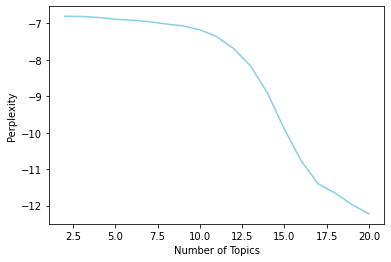

In [65]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

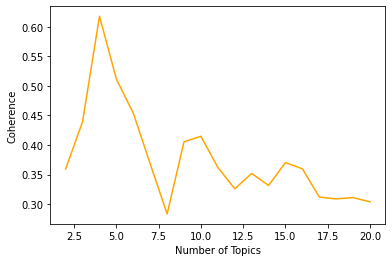

In [66]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Most salient topic per file using results of Model of choice

In [67]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1, 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sent_topics_df = pd.concat([listings_df,sent_topics_df], axis=1)
    return(sent_topics_df)

In [69]:
# choosing the model
df_topic_sents_keywords = format_topics_sentences(ldamodel=models[2], corpus=corpus, texts=lst_texts)

# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.to_csv('results/dominant_topic.csv', index=False)

### Visualize the topics

In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[3], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.258253 -0.020749       1        1  47.573418
2      0.216731 -0.111157       2        1  23.884001
4     -0.245062 -0.294883       3        1  11.175030
0     -0.043185  0.256927       4        1   9.632885
3     -0.186737  0.169862       5        1   7.734669, topic_info=          Term         Freq        Total Category  logprob  loglift
83        stay  3087.000000  3087.000000  Default  30.0000  30.0000
9     downtown  7994.000000  7994.000000  Default  29.0000  29.0000
123       room  3692.000000  3692.000000  Default  28.0000  28.0000
141    bedroom  3179.000000  3179.000000  Default  27.0000  27.0000
51      coffee  2029.000000  2029.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
6939  thousand   188.437347   190.949677   Topic5  -4.7838   2.5462
239      place  1102.268188  1686.458374   Topic5  -3.0174   2.1342
16         lot   250.050980   554.072632   Topic5  -4.5009   1.7638
276       good   267.115845  1258.996582   Topic5  -4.4349   1.0091
105   property   206.383499   834.695496   Topic5  -4.6928   1.1621

[219 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2641      4  0.995116     ability
185       1  0.767494      access
185       2  0.231753      access
37        5  0.997735  additional
46        1  0.999194     amenity
...     ...       ...         ...
45        2  0.999536        wifi
5259      4  0.997698   wont_need
247       5  0.998186        work
815       4  0.998092       would
176       2  0.998812        yard

[225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])